# Study effects of using pre-initialized weights in a Convolutional Neural Network

### Import headers

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Activation, Flatten, Dropout
from keras.models import Sequential
from keras import backend as K
from keras.models import Model
from keras.utils import np_utils

from keras.datasets import mnist
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

%matplotlib inline

Using Theano backend.
Using gpu device 0: Quadro M1000M (CNMeM is disabled, cuDNN 5105)
/home/abhishek/workspace/94.15/venv/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


### Load data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x = np.append(x_train,x_test,axis=0)
y = np.append(y_train,y_test,axis=0)
print"x shape : ", x.shape
print"y shape : ", y.shape

count = 0

x shape :  (70000, 28, 28)
y shape :  (70000,)


### Define variables

In [3]:
epochs_for_cae = 40
epochs_for_cnn = 20

training_samples_for_cae   = 25000
validation_samples_for_cae = 5000

training_samples_for_cnn   = 25000
testing_samples_for_cnn = 10000
validation_samples_for_cnn = 5000

sum = training_samples_for_cae+training_samples_for_cnn+validation_samples_for_cae+validation_samples_for_cnn+testing_samples_for_cnn

if(sum>70000):
    print("***********\nOnly 70,000 data points, re-define variables such that their sum is less than 70,000.\n***********")

### Autoencoder data

In [4]:
cae_x_train = np.reshape(x[count:count+training_samples_for_cae], (training_samples_for_cae, 1, 28, 28))
count = count + training_samples_for_cae

cae_x_validation = np.reshape(x[count:count+validation_samples_for_cae], (validation_samples_for_cae, 1, 28, 28))
count = count + validation_samples_for_cae

print "cae_x_train shape : ", cae_x_train.shape
print "cae_x_validation shape : ", cae_x_validation.shape

cae_x_train shape :  (25000, 1, 28, 28)
cae_x_validation shape :  (5000, 1, 28, 28)


### CAE model

In [5]:
print "Output shapes after subsequent layers : "

cae = Sequential()

cae.add(Conv2D(8, 3, 3, border_mode='same',  input_shape=(1, 28, 28),name='conv1' ))
cae.add(Activation('relu'))
print(cae.layers[-1].output_shape)

cae.add(Conv2D(16, 3, 3, border_mode='same', name='conv2'))
cae.add(Activation('relu'))
print(cae.layers[-1].output_shape)

cae.add(Conv2D(8, 3, 3 , border_mode='same', name='conv3'))
cae.add(Activation('relu'))
cae.add(MaxPooling2D(pool_size=(2, 2), border_mode='same', name='encoded'))
print(cae.layers[-1].output_shape)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
cae.add(UpSampling2D(size=(2, 2)))

cae.add(Conv2D(8, 3, 3, activation='relu', border_mode='same'))
print(cae.layers[-1].output_shape)

cae.add(Conv2D(16, 3, 3, activation='relu', border_mode='same'))
print(cae.layers[-1].output_shape)

cae.add(Conv2D(8, 3, 3, activation='relu',  border_mode='same'))
print(cae.layers[-1].output_shape)

cae.add(Conv2D(1, 3, 3, activation='sigmoid', border_mode='same', name='decoded'))

print(cae.layers[-1].output_shape)

cae.compile(optimizer='adadelta', loss='binary_crossentropy')


Output shapes after subsequent layers : 
(None, 8, 28, 28)
(None, 16, 28, 28)
(None, 8, 14, 14)
(None, 8, 28, 28)
(None, 16, 28, 28)
(None, 8, 28, 28)
(None, 1, 28, 28)


### Model summary

In [6]:
cae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv1 (Convolution2D)            (None, 8, 28, 28)     80          convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 8, 28, 28)     0           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 16, 28, 28)    1168        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 16, 28, 28)    0           conv2[0][0]                      
___________________________________________________________________________________________

### Diagram

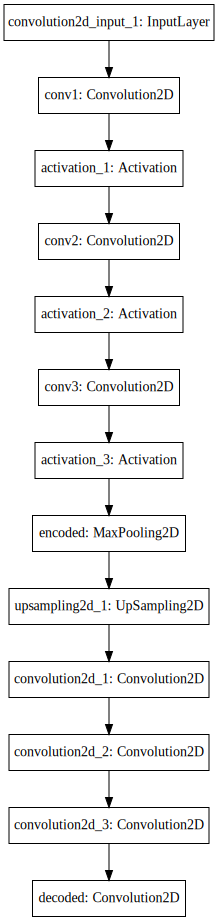

In [7]:
SVG(model_to_dot(cae).create(prog='dot', format='svg'))

### Train

In [8]:
cae.fit(cae_x_train, cae_x_train,
	                nb_epoch=epochs_for_cae,
	                batch_size=128,
                    verbose=1,
	                shuffle=True,
	                validation_data=(cae_x_validation, cae_x_validation))

Train on 25000 samples, validate on 5000 samples
Epoch 1/40
25000/25000 [==============================] - 13s - loss: 0.1737 - val_loss: 0.0773

### Save model

In [9]:
cae_name = 'mnist_cae_cccp_'+str(epochs_for_cae)+'e_'+str(training_samples_for_cae)+'i.h5'
cae.save(cae_name)

### Check results and encoded representation

Results (orignal vs reconstructed image): 


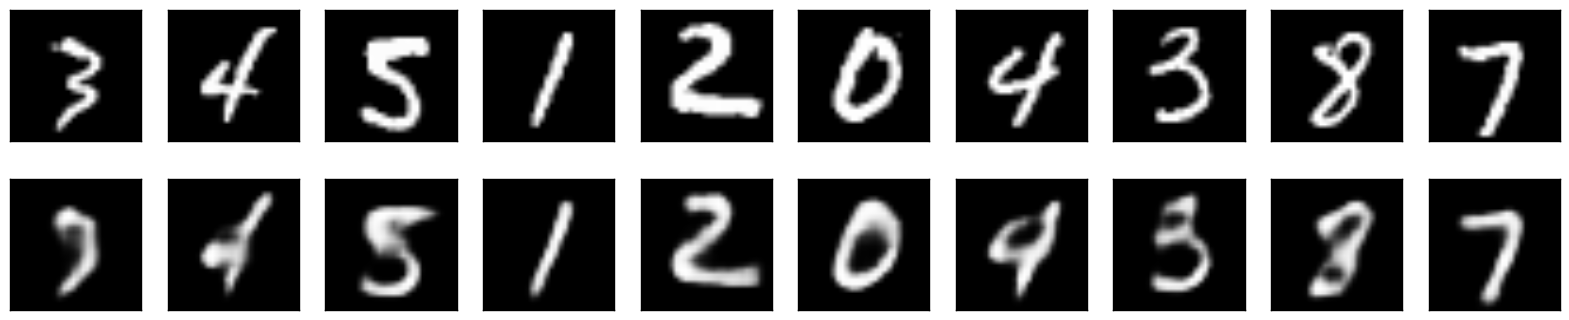

Encoded representation : 


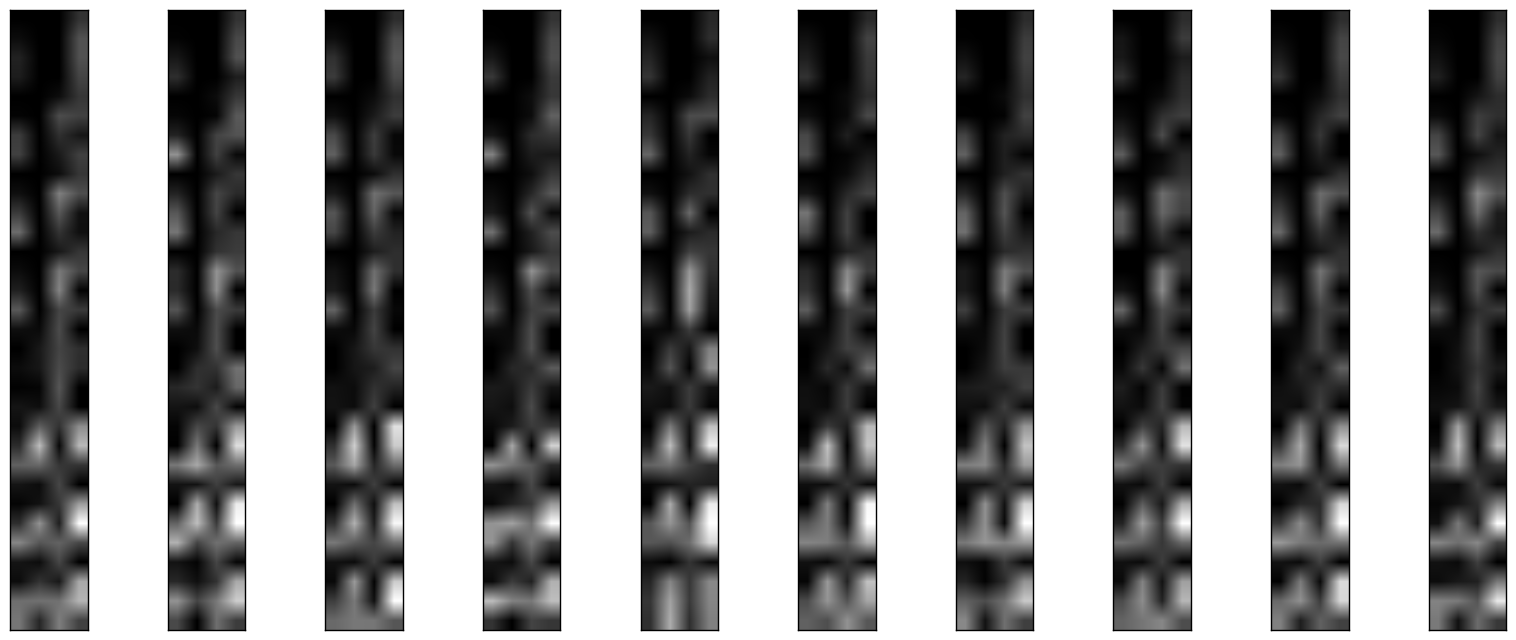

In [10]:
test = cae_x_validation
test = np.reshape(test,(validation_samples_for_cae,1,28,28))
decoded_imgs = cae.predict(test)
encoder = Model(input=cae.input, output=cae.get_layer('encoded').output)
encoded_imgs = encoder.predict(test)

print "Results (orignal vs reconstructed image): "
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print "Encoded representation : "
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### CNN data

In [10]:
cnn_x_train = np.reshape(x[count:count+training_samples_for_cnn], (training_samples_for_cnn, 1, 28, 28))
cnn_y_train = np_utils.to_categorical(y[count:count+training_samples_for_cnn], nb_classes=10)
count = count + training_samples_for_cnn

cnn_x_test = np.reshape(x[count:count+testing_samples_for_cnn], (testing_samples_for_cnn, 1, 28, 28))
cnn_y_test = np_utils.to_categorical(y[count:count+testing_samples_for_cnn], nb_classes=10)
count = count + testing_samples_for_cnn

cnn_x_validation = np.reshape(x[count:count+validation_samples_for_cnn], (validation_samples_for_cnn, 1, 28, 28))
cnn_y_validation = np_utils.to_categorical(y[count:count+validation_samples_for_cnn], nb_classes=10)
count = count + validation_samples_for_cnn

print "cnn_x_train shape : ", cnn_x_train.shape
print "cnn_x_test shape : ", cnn_x_test.shape
print "cnn_x_validation shape : ", cnn_x_validation.shape

print "cnn_y_train shape : ", cnn_y_train.shape
print "cnn_y_test shape : ", cnn_y_test.shape
print "cnn_y_validation shape : ", cnn_y_validation.shape

cnn_x_train shape :  (25000, 1, 28, 28)
cnn_x_test shape :  (10000, 1, 28, 28)
cnn_x_validation shape :  (5000, 1, 28, 28)
cnn_y_train shape :  (25000, 10)
cnn_y_test shape :  (10000, 10)
cnn_y_validation shape :  (5000, 10)


### CNN model

In [11]:
model = Sequential()

model.add(Conv2D(8, 3, 3, activation='relu', border_mode='same',  input_shape=(1, 28, 28), name='conv1' ))

model.add(Conv2D(16, 3, 3, activation='relu', border_mode='same', name='conv2'))

model.add(Conv2D(8, 3, 3, activation='relu', border_mode='same', name='conv3'))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same', name='encoded'))

model.add(Flatten())
model.add(Dense(16))

model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))


### Model summary

In [12]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv1 (Convolution2D)            (None, 8, 28, 28)     80          convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 16, 28, 28)    1168        conv1[0][0]                      
____________________________________________________________________________________________________
conv3 (Convolution2D)            (None, 8, 28, 28)     1160        conv2[0][0]                      
____________________________________________________________________________________________________
encoded (MaxPooling2D)           (None, 8, 14, 14)     0           conv3[0][0]                      
___________________________________________________________________________________________

### Diagram

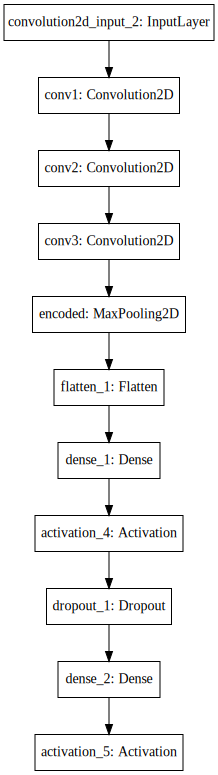

In [13]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### APPROACH 1  :  Unitialiazed CNN 

In [14]:
model1 = model
model1.compile(optimizer='adadelta', loss='categorical_crossentropy',metrics=['accuracy'])

model1.fit(cnn_x_train, cnn_y_train,
                nb_epoch=epochs_for_cnn,
                batch_size=16,
                shuffle=True,
                verbose=1,
                validation_data=(cnn_x_validation, cnn_y_validation))

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
25000/25000 [==============================] - 13s - loss: 1.2829 - acc: 0.5217 - val_loss: 0.4114 - val_acc: 0.9286

### Save model

In [15]:
name = 'mnist_CNN_'+str(epochs_for_cnn)+'e_'+str(training_samples_for_cnn)+'i.h5'
model1.save(name)

### Results of approach 1

In [16]:
params1 = model1.metrics_names
results1 = (model1.evaluate(cnn_x_test,cnn_y_test,verbose=0))

print params1[0]," : ", results1[0]
print params1[1]," : ", results1[1]

loss  :  0.119442222269
acc  :  0.9706


### APPROACH 2 :  Intialiazed CNN 

In [17]:
model2 = model
model2.load_weights(cae_name, by_name=True)
model2.compile(optimizer='adadelta', loss='categorical_crossentropy',metrics=['accuracy'])
model2.fit(cnn_x_train, cnn_y_train,
                nb_epoch=epochs_for_cnn,
                batch_size=16,
                shuffle=True,
                verbose=1,
                validation_data=(cnn_x_validation, cnn_y_validation))

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
25000/25000 [==============================] - 13s - loss: 1.8523 - acc: 0.6000 - val_loss: 0.1355 - val_acc: 0.9746

### Save model

In [18]:
name = 'mnist_initializedCNN_'+str(epochs_for_cnn)+'e_'+str(training_samples_for_cnn)+'i.h5'
model2.save(name)

### Results of approach 2

In [19]:
params2 = model2.metrics_names
results2 = (model2.evaluate(cnn_x_test,cnn_y_test,verbose=0))
print params2[0]," : ", results2[0]
print params2[1]," : ", results2[1]

loss  :  0.100158229173
acc  :  0.9726
